<a href="https://colab.research.google.com/github/kbarone/satellite_deeplearning/blob/main/SatelliteSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/satellite_deeplearning

/content/drive/MyDrive/Github/satellite_deeplearning


In [18]:
!pip install patchify
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=6627e1d0e5493d7d0e8940f7651370af1c7da0dd500841597ea7eeb973f3cd3a
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=d81a9a3

In [4]:
from satellite_utils import *
import warnings
warnings.filterwarnings('ignore')

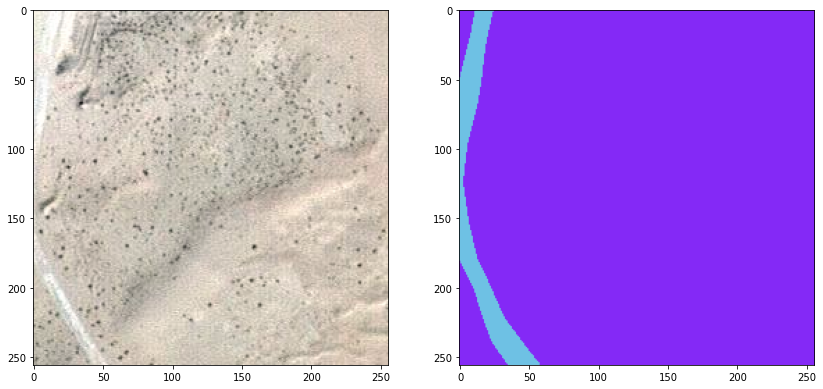

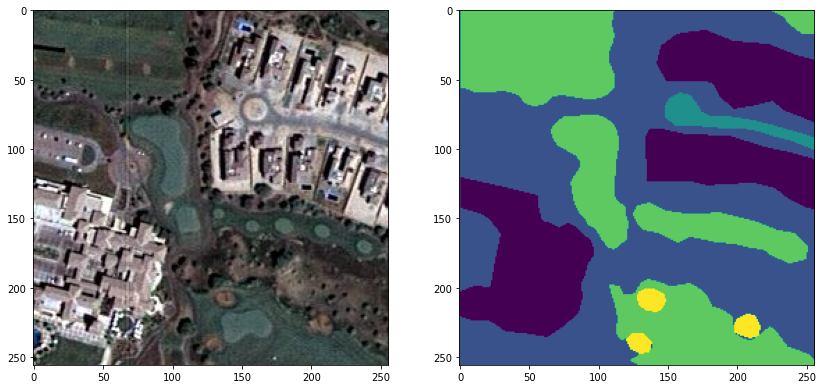

In [5]:
image_dataset, labels = run()

In [6]:
print(len(image_dataset))
print(len(labels))

945
945


In [7]:
total_classes = len(np.unique(labels))

In [8]:
labels_categorical_dataset = np.squeeze(to_categorical(labels, total_classes))

In [9]:
main_training_dataset = image_dataset

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(main_training_dataset, labels_categorical_dataset, 
                 test_size=0.2, random_state=100)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [11]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(567, 256, 256, 3)
(189, 256, 256, 3)
(189, 256, 256, 3)
(567, 256, 256, 6)
(189, 256, 256, 6)
(189, 256, 256, 6)


In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torch import nn
import torch

In [13]:
class SatelliteData(Dataset):
  def __init__(self, dataframe, labels=None, transforms=None):
    self.dataframe = dataframe
    self.labels = labels
    self.transforms = transforms

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    sample = {}
    x_arr = self.dataframe[idx]
    if self.transforms is not None:
      x_arr = self.transforms(image=x_arr)
    x_arr = x_arr.transpose(2,0,1)
    sample['xdata'] = torch.from_numpy(x_arr)
    if self.labels is not None:
      sample['label'] = torch.from_numpy(self.labels[idx])

    return sample

In [14]:
import albumentations as A

training_transformations = A.Compose(
    [A.RandomCrop(128, 128),
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.VerticalFlip()])

In [26]:
class CrossDice(nn.Module):
  def __init__(self):
    super().__init__()
    self.cross = nn.CrossEntropyLoss(reduction="none")

  def forward(self, pred, true_labels):
    cross_loss = self.cross(pred, true_labels).mean()
    dice_loss = 1 - (2.0 * torch.sum(pred * true_labels)) / (torch.sum(pred + true_labels) + 1e-7)
    return (0.5 * cross_loss) + (0.5 * dice_loss)

In [16]:
def intersection_and_union(pred, true_labels):
    # Intersection and union totals
    intersection = np.logical_and(true_labels, pred)
    union = np.logical_or(true_labels, pred)
    return intersection.sum()/ union.sum()

In [19]:
import segmentation_models_pytorch as smp

class Unet(nn.Module):
    def __init__(self, num_classes):
        super(Unet, self).__init__()
        self.model = smp.Unet(classes=num_classes)
    def forward(self, x):
        return self.model(x)

In [20]:
train_dataset = SatelliteData(X_train, y_train)
val_dataset = SatelliteData(X_val, y_test)
test_dataset = SatelliteData(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [29]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def fit(epochs, model, train_dataloader, val_dataloader, criterion, optimizer, scheduler=None):
    for e in range(epochs):
        train_loss = 0
        train_iou = 0
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader)):
            
            images = batch['xdata']
            labels = batch['label']
            images = images.to(device)
            labels = labels.to(device)
            labels = torch.permute(labels, (0,3,1,2))

            outputs = model(images.float())
            train_iou += intersection_and_union(outputs.cpu().detach().numpy(), labels.cpu().numpy())
            loss = criterion(outputs, labels.float())
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        else:
            model.eval()
            val_loss = 0
            val_iou = 0
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_dataloader)):
                    images = data['xdata']
                    labels = data['label']
                    images = images.to(device)
                    labels = labels.to(device)
                    labels = torch.permute(labels, (0,3,1,2))

                    outputs = model(images.float())
                    val_iou += intersection_and_union(outputs.cpu().detach().numpy(), labels.cpu().numpy())
                    loss = criterion(outputs, labels.float())

                    val_loss += loss.item()
                    if scheduler is not None:
                        scheduler.step(val_loss)
        train_avg = train_loss / len(train_dataloader)
        val_avg = val_loss / len(val_dataloader)
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(e+1,train_avg, val_avg))

In [22]:
max_lr = 1e-3
epoch = 5
weight_decay = 1e-4

model = Unet(num_classes=6)
model = model.float().to(device)
#criterion = nn.CrossEntropyLoss()
criterion = CrossDice()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
# add scheduler
fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer)#, sched)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

100%|██████████| 24/24 [00:01<00:00, 18.33it/s]


|EPOCH 1| TRAIN_LOSS 0.8404522899170996| VALID_LOSS 2.255634148915609|


100%|██████████| 24/24 [00:01<00:00, 18.35it/s]


|EPOCH 2| TRAIN_LOSS 0.685535451476003| VALID_LOSS 2.3303649673859277|


100%|██████████| 24/24 [00:01<00:00, 18.01it/s]


|EPOCH 3| TRAIN_LOSS 0.6411218412325416| VALID_LOSS 10.85837827126185|


100%|██████████| 24/24 [00:01<00:00, 16.08it/s]


|EPOCH 4| TRAIN_LOSS 0.5974818992782647| VALID_LOSS 2.6152422726154327|


100%|██████████| 24/24 [00:01<00:00, 17.88it/s]

|EPOCH 5| TRAIN_LOSS 0.5844859052711809| VALID_LOSS 2.848734771211942|


In [27]:
model2 = Unet(num_classes=6)
model2 = model.float().to(device)
criterion2 = CrossDice()
fit(epoch, model2, train_dataloader, val_dataloader, criterion2, optimizer)#, sched)

100%|██████████| 24/24 [00:01<00:00, 18.20it/s]


|EPOCH 1| TRAIN_LOSS 0.8711981429180629| VALID_LOSS 1.5934576864043872|


100%|██████████| 24/24 [00:01<00:00, 18.13it/s]


|EPOCH 2| TRAIN_LOSS 0.7316085192519175| VALID_LOSS 1.5778912752866745|


100%|██████████| 24/24 [00:01<00:00, 17.99it/s]


|EPOCH 3| TRAIN_LOSS 0.7018166662941516| VALID_LOSS 1.5445200552543004|


100%|██████████| 24/24 [00:01<00:00, 15.77it/s]


|EPOCH 4| TRAIN_LOSS 0.678722363122752| VALID_LOSS 1.5029364377260208|


100%|██████████| 24/24 [00:01<00:00, 16.46it/s]

|EPOCH 5| TRAIN_LOSS 0.6562949872352708| VALID_LOSS 1.6109119951725006|


In [30]:
epoch=10
model3 = Unet(num_classes=6)
model3 = model.float().to(device)
criterion2 = CrossDice()
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=4)
fit(epoch, model3, train_dataloader, val_dataloader, criterion2, optimizer, sched)

  0%|          | 0/71 [00:00<?, ?it/s]


TypeError: ignored